In [1]:
push!(LOAD_PATH,"C:/JMB/DINEOF.jl/src","."); using DINEOF
using PyPlot
using LinearAlgebra
using Arpack
using Random
using Statistics
using Optim

In [2]:
?DINEOF_musquare

search: DINEOF_musquare



```
musquare,cvOI,J1,J2=DINEOF_musquare(X,U,S,V,missingvalues,cvpoints,cvEOF;musquarer=[.01,1.].*var(X),musquarew=[1.0,1.0],maxjsamples=100)
```

# Estimator of mu_eff^2

# Input:

  * `X`: a two-dimensional array of size MxN with N<=M and no missing values.
  * `U,S,V` decomposition
  * `missingvalues` : list of indexes of missing values in original array
  * `cvpoints` : list of indexes used for crossvalidation
  * `cvEOF` : cross validator from EOF decompisition. musquare tries to find OI with CV estimator to be close to that one if musquarew[2] is not zero
  * `musquarer` : range in which to search for optimal musquare
  * `musquarew` : weighting of the two criteria: OI reconstruction close to EOF decomposition or OI CV value close to EOF CV value
  * `maxjsamples` : maximum number of (random) columns to be used for the optimization

# Output:

  * `musquare`: requested value for musquare
  * `cvOI`: cross validator value when OI is used
  * `J1`: relative difference of OI and EOF reconstruction
  * `J2`: relative error on CV estimator


In [3]:
Random.seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

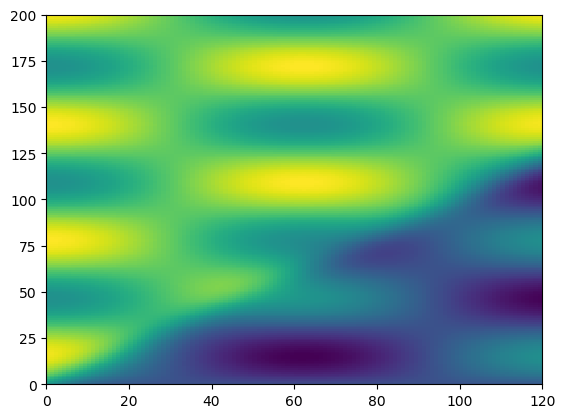

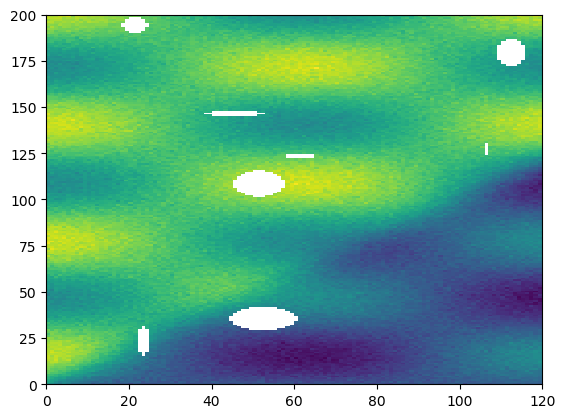

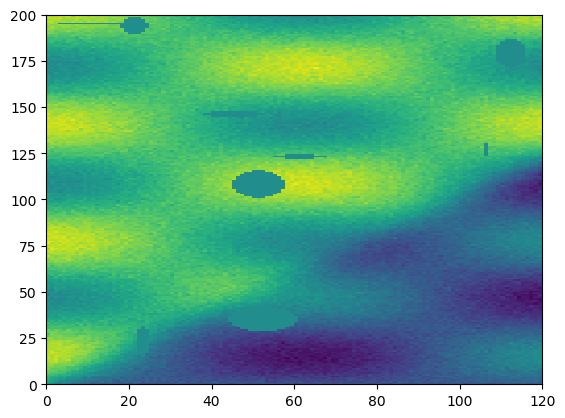

200×120 Array{Float64,2}:
 0.218735  0.0343256  -0.191273   …  -0.891053  -0.847946   -0.970491 
 0.502907  0.358108    0.0704869     -0.743091  -0.761977   -0.840981 
 0.606791  0.391246    0.325056      -0.766155  -0.580835   -0.71749  
 0.726186  0.574245    0.369344      -0.648603  -0.656046   -0.707342 
 0.819107  0.639225    0.698453      -0.642786  -0.473378   -0.65252  
 0.959583  0.907972    0.774662   …  -0.487413  -0.467832   -0.547632 
 1.27856   1.08541     1.09794       -0.282911  -0.458674   -0.524018 
 1.31328   1.30832     1.18674       -0.470059  -0.435833   -0.522744 
 1.47377   1.24595     1.17919       -0.147754  -0.0942621  -0.381302 
 1.53729   1.41452     1.30438       -0.245685  -0.347643   -0.214076 
 1.61775   1.56305     1.4014     …  -0.13713   -0.277916   -0.125948 
 1.64699   1.71849     1.55325       -0.205216  -0.0253182  -0.0201675
 1.70712   1.84101     1.87834       -0.142924  -0.106601    0.103276 
 ⋮                                ⋱                

In [4]:
NX=200
NY=120
X=zeros(Float64,NX,NY)
      for j=1:NY
            for i=1:NX
        X[i,j]=sin(i/10)*cos(j/20)+tanh((i-j)/10)
            end
        end
pcolor(X)
figure()
# use cvmask routing to create some bubbles and missing points
X=X+0.1*randn(size(X))
cvmask=DINEOF_cvmask(X,0.02,cvmethod="Bubbles",maxbubblesize=[20,20])
X[cvmask].=NaN
# Now real cv mask
cvmask=DINEOF_cvmask(X,0.05,cvmethod="Bubbles",maxbubblesize=[20,20])
pcolor(X)
NM=sum(isnan.(X))
missingvalues=zeros(Int,(NM,2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
            if isnan(X[i,j])
                icount=icount+1
                missingvalues[icount,1]=i
                missingvalues[icount,2]=j
                # Put a random value with average variance of present data so that we can keep an eye on how total variane
                # behaves.
                X[i,j]=0
            end
        end
    end
cvpoints=zeros(Int,(sum(cvmask),2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
        if  cvmask[i,j]
                icount=icount+1
                cvpoints[icount,1]=i
                cvpoints[icount,2]=j
                
            end
        end
    end
figure()
pcolor(X)
XORI=deepcopy(X)

In [5]:
@time U,S,V,cv,cva=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5)

@time mus,varest,thetaout,thetacv=DINEOF_musquare(X,U,S,V,missingvalues,cvpoints,cv)

svds!: variance and mean of the entry matrix: 0.9752964467750473 , 0.3822095334422443 ; intial variance at points to fill in: 0.1460841274541398 


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:96


Convergence for 1 eofs, relative change 0.0007614312671349143 after 6 iterations
Eof loop 1 with mean squared misfit: 0.3560964323418935 
Convergence for 2 eofs, relative change 0.0005204366429044226 after 6 iterations
Eof loop 2 with mean squared misfit: 0.4976009010321714 
Eof loop 3 with mean squared misfit: 0.18794475397331778 
Convergence for 4 eofs, relative change 0.0008049394711630537 after 10 iterations
Eof loop 4 with mean squared misfit: 0.10990662078307617 
Convergence for 5 eofs, relative change 0.0006718222479550087 after 8 iterations
Eof loop 5 with mean squared misfit: 0.09670304573677677 
Cross validation value (mean squared misfit): 0.09670304573677677 for 5 EOFs
Estimation for musquare based on DeRozier type of analysis: 0.015286062677647533
Estimation of mean error variance of reconstuctions: -0.08141698305912923 


┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.1634450149636582
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:285


  8.778236 seconds (19.41 M allocations: 967.623 MiB, 6.16% gc time)
musquare optimization: Both OI-EOF error and CV coherence
tutu = Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.009922, 0.992195]
 * Minimizer: 9.809989e-01
 * Minimum: 8.401609e+02
 * Iterations: 8
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-02*|x|+1.0e-07): true
 * Objective Function Calls: 9
CV estimator from EOF 0.09670304573677677 is now 0.015400794756871714 if OI is used
Optimal musquare is 0.9809988749401928
Relative error on reconstruction 1.782518615121464e-5, relative error on CV estimator 0.7068460481690781
The two criteria to compare OI and EOF are: reconstruction 0.42780446762915136, closest CV 839.7331052248649
  1.972552 seconds (3.81 M allocations: 319.400 MiB, 7.10% gc time)


(0.9809988749401928, 0.015400794756871714, 1.782518615121464e-5, 0.7068460481690781)

For random point clouds 

svds!: variance and mean of the entry matrix: 0.983726435579065 , 0.39265822524463145 ; intial variance at points to fill in: 0.15418048185226438 
Convergence for 1 eofs, relative change 7.940475734091597e-5 after 4 iterations
Eof loop 1 with mean squared misfit: 0.5122035957939345 


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:96


Convergence for 2 eofs, relative change 0.0001323194098454057 after 4 iterations
Eof loop 2 with mean squared misfit: 0.2139720096704245 
Convergence for 3 eofs, relative change 0.00015695618992475055 after 4 iterations
Eof loop 3 with mean squared misfit: 0.03875518629817825 
Convergence for 4 eofs, relative change 0.0008135566497724523 after 3 iterations
Eof loop 4 with mean squared misfit: 0.022623185076166657 
Convergence for 5 eofs, relative change 0.0009755422884362328 after 3 iterations
Eof loop 5 with mean squared misfit: 0.0188816504641111 
Cross validation value (mean squared misfit): 0.0188816504641111 for 5 EOFs
Estimation for musquare based on DeRozier type of analysis: 0.015001143958219608
Estimation of mean error variance of reconstuctions: -0.0038805065058914925 
  0.246654 seconds (142.75 k allocations: 8.093 MiB, 4.35% gc time)


┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.1537859773736852
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:285


musquare optimization: Both OI-EOF error and CV coherence

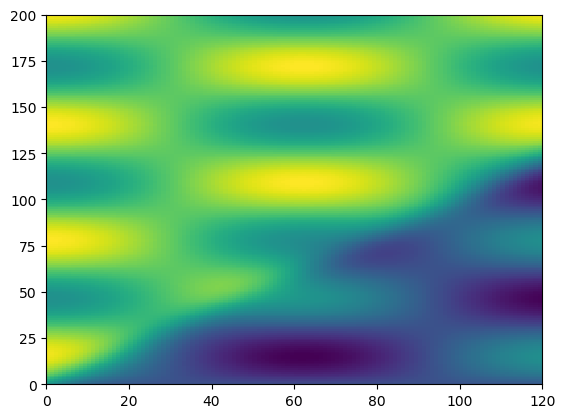

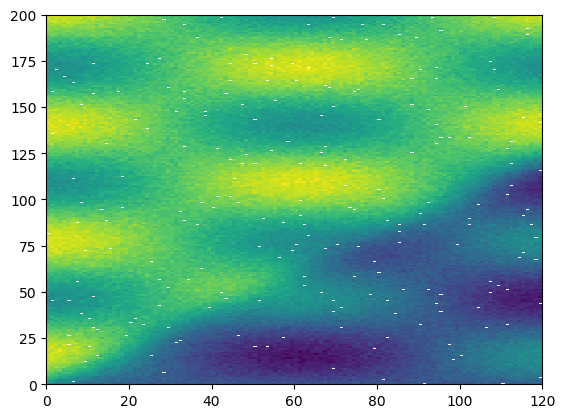

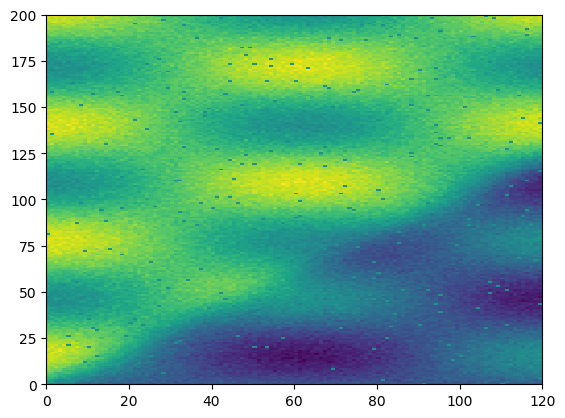


tutu = Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.009917, 0.991680]
 * Minimizer: 4.508039e-01
 * Minimum: 1.513592e-01
 * Iterations: 6
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-02*|x|+1.0e-07): true
 * Objective Function Calls: 7
CV estimator from EOF 0.0188816504641111 is now 0.018770297999659676 if OI is used
Optimal musquare is 0.45080393368804533
Relative error on reconstruction 5.929858699821998e-6, relative error on CV estimator 3.477921369756054e-5
The two criteria to compare OI and EOF are: reconstruction 0.14231660879572794, closest CV 0.00904259556136574
  0.161125 seconds (100.29 k allocations: 101.749 MiB, 18.26% gc time)


(0.45080393368804533, 0.018770297999659676, 5.929858699821998e-6, 3.477921369756054e-5)

In [6]:
NX=200
NY=120
X=zeros(Float64,NX,NY)
      for j=1:NY
            for i=1:NX
        X[i,j]=sin(i/10)*cos(j/20)+tanh((i-j)/10)
            end
        end
pcolor(X)
figure()
# use cvmask routing to create some bubbles and missing points
X=X+0.1*randn(size(X))
cvmask=DINEOF_cvmask(X,0.01,cvmethod="Random",maxbubblesize=[20,20])
X[cvmask].=NaN
# Now real cv mask
cvmask=DINEOF_cvmask(X,0.01,cvmethod="Random",maxbubblesize=[20,20])
pcolor(X)
NM=sum(isnan.(X))
missingvalues=zeros(Int,(NM,2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
            if isnan(X[i,j])
                icount=icount+1
                missingvalues[icount,1]=i
                missingvalues[icount,2]=j
                # Put a random value with average variance of present data so that we can keep an eye on how total variane
                # behaves.
                X[i,j]=0
            end
        end
    end
cvpoints=zeros(Int,(sum(cvmask),2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
        if  cvmask[i,j]
                icount=icount+1
                cvpoints[icount,1]=i
                cvpoints[icount,2]=j
                
            end
        end
    end
figure()
pcolor(X)
XORI=deepcopy(X)
@time U,S,V,cv,cva=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5)
mup=collect(0.005:0.01:2)
@time mus,varest,thetaout,thetacv=DINEOF_musquare(X,U,S,V,missingvalues,cvpoints,cv)


To save time, there is no need to optimize on all columns



In [7]:
@time mus,varest,thetaout,thetacv=DINEOF_musquare(X,U,S,V,missingvalues,cvpoints,cv;maxjsamples=20)


musquare optimization: Both OI-EOF error and CV coherence
tutu = Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.009917, 0.991680]
 * Minimizer: 1.593850e-01
 * Minimum: 1.013438e+00
 * Iterations: 9
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.0e-02*|x|+1.0e-07): true
 * Objective Function Calls: 10
CV estimator from EOF 0.0188816504641111 is now 0.020040767479007637 if OI is used
Optimal musquare is 0.15938500920357845
Relative error on reconstruction 1.4005786414514843e-6, relative error on CV estimator 0.0037685532342230025
The two criteria to compare OI and EOF are: reconstruction 0.033613887394835625, closest CV 0.9798238408979807
  0.090268 seconds (108.53 k allocations: 32.397 MiB, 11.42% gc time)


(0.15938500920357845, 0.020040767479007637, 1.4005786414514843e-6, 0.0037685532342230025)

In [8]:
cv

0.0188816504641111